In [1]:
import time
import random
import numpy as np
import pulp as plp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 

    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue    
                    
    return float(opt_model.objective.value()), varsdict

def Prepare_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("Black")
        else:
            node_colors.append("Silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

In [2]:
def create_data(n,num):
    
    k = 0.5
    
    if num==1:
        G = nx.grid_2d_graph(n,n)
    if num==2:
        G = nx.triangular_lattice_graph(n,n)
    if num==3:
        G= nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Prepare_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    

    return G

In [6]:
import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)

In [108]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

def color_of_frustration(H):
    
    positive=0
    negative=0

    for n1,n2,val in H.edges.data():
        
        G = H.copy() 
        color1 = G.nodes[n1]['color']
        color2 = G.nodes[n2]['color']
        #print(n1,n2,color1,color2)
        #print(color1 == color2 or color2==color1)
        if color1 == color2 or color2==color1:
            #print("true")
            if color1 == color2 == "Black":
                #print("\tadd negative")
                negative +=1
            if color1 == color2 == "Silver":
                #print("\tadd positive")
                positive +=1
                
    return positive,negative

def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    #print("p=",p,"n=",n)
    
    if p>n:
        return int(np.sqrt((p-n)**2))
    else:
        return int(np.sqrt((n-p)**2))
    
def Plot2D(G,size=5):

    H0 = G.copy()
    pos =nx.get_node_attributes(H0,'pos')
    node_colors=nx.get_node_attributes(H0,'color')

    edge_colors = []
    for n1,n2,val in H0.edges.data():

        #print(n1,n2)
        if H0.nodes[n1]['color']==H0.nodes[n2]['color']:

            if H0.nodes[n1]['color'] ==H0.nodes[n2]['color'] == "Black":
                edge_colors.append("red")
                #negative +=1
            if H0.nodes[n1]['color'] ==H0.nodes[n2]['color'] == "Silver":
                edge_colors.append("green")
                #positive +=1
        else:
                edge_colors.append("lightgrey")

    attr2 = {}
    for edge,color in zip(H0.edges(),edge_colors):

        #print(edge,color)
        attr2[edge]=color

    nx.set_edge_attributes(H0, attr2, 'edge_color')
    
    edge_colors=nx.get_edge_attributes(H0,'edge_color')

    fig, ax = plt.subplots(figsize=(size,size))
    nx.draw(H0,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)

<br>
<br>
<br>
<br>
<br>

In [12]:
def Quench_Process(Gs):

    total=[]
    Delta = []
    for i in tqdm(range(len(Gs))):
        
        #print(i)
        
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        deltas = []
        deltas.append(calculate_delta(H))
        
        #print(calculate_delta(H))
        G = H.copy()
        for k in range(1,500):
            
            #print("\t",k)
            
            #H = nx.algorithms.double_edge_swap(H, nswap=1)
            
            nx.algorithms.connected_double_edge_swap(G, nswap=1)
            #print("\t\t",calculate_delta(G),frustration_count(G))
            
            #H = Add_Weights(H,1.0)
            
            fr = frustration_count(G)
            res.append(fr)
            #print("\t",calculate_delta(H),frustration_count(H))
            deltas.append(calculate_delta(G))

        total.append(res) 
        Delta.append(deltas)
        
    return np.array(total),np.array(Delta)

def Get_Probabilites(data,Edge,repeat):

    p_t=[]
    for t in range(len(data[0])):

        #print(means[:,t])

        prob=[]
        for i in range(0,Edge):
            prob.append(np.count_nonzero(np.array(data[:,t]) == i))
        p_t.append(np.array(prob)/repeat)

    P_t = np.array(p_t)

    p_even=[]
    for l in P_t:
        p_even.append(l[::2])

    P_even = np.array(p_even)

    return P_t,P_even

def Get_Means(data):
    
    total = np.array(data)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))

    return np.array(final)

In [24]:
from collections import Counter

def Create_Initial_Graphs(repeat_num,choice,N,delta = 0):

    Gs = []
    d_target = delta
    
    for i in tqdm(range(repeat_num)):

        G0 = create_data(N,choice)
        print("created",i,len(G0.edges()))
        edge = len(G0.copy().edges())
        H = G0.copy() 

        while (calculate_delta(H) != d_target):

            H = simulated_annealing(G0.copy(),target=d_target)

        Gs.append(H.copy())
        print("finished annealing","d =",calculate_delta(H),"f =",frustration_count(H))
        
    avg_f = []
    for gs in Gs:
        avg_f.append(frustration_count(gs))

    avg_F = Counter(avg_f)
    
    #print(avg_f)
    
    #print(avg_F)
    
    most_common = max(avg_F, key=avg_F.get)
    
    #print(most_common)
    
    GS = []
    for gs in Gs:
        if frustration_count(gs) == most_common:
            GS.append(gs)
        if len(GS) == 100:
            break
    
        
    return GS

In [34]:
def Quench_Process2(Gs):
    
    %matplotlib notebook

    total=[]
    for i in tqdm(range(len(Gs))):
    
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        G = H.copy()
        for k in range(1,1000):
            
            nx.algorithms.connected_double_edge_swap(G, nswap=1)
            
            fr = frustration_count(G)
            res.append(fr)

        total.append(res) 
        
    return np.array(total)

<br>
<br>
<br>
<br>
<br>

# L = 165, d = 0 

In [23]:
repeat_num = 500
N = 10
delta = 0

Gs = Create_Initial_Graphs(repeat_num,2,N,delta)

Edge = len(Gs[0].copy().edges())

  0%|          | 0/500 [00:00<?, ?it/s]

created 0 165


  0%|          | 1/500 [00:00<05:48,  1.43it/s]

finished annealing d= 0 f= 54
created 1 165


  0%|          | 2/500 [00:10<28:48,  3.47s/it]

finished annealing d= 0 f= 86
created 2 165


  1%|          | 3/500 [00:17<36:54,  4.46s/it]

finished annealing d= 0 f= 74
created 3 165


  1%|          | 4/500 [00:20<32:31,  3.93s/it]

finished annealing d= 0 f= 70
created 4 165


  1%|          | 5/500 [00:24<32:52,  3.98s/it]

finished annealing d= 0 f= 76
created 5 165


  1%|          | 6/500 [00:25<27:10,  3.30s/it]

finished annealing d= 0 f= 66
created 6 165


  1%|▏         | 7/500 [00:31<32:24,  3.95s/it]

finished annealing d= 0 f= 72
created 7 165


  2%|▏         | 8/500 [00:39<42:40,  5.21s/it]

finished annealing d= 0 f= 96
created 8 165


  2%|▏         | 9/500 [00:44<42:47,  5.23s/it]

finished annealing d= 0 f= 72
created 9 165


  2%|▏         | 10/500 [00:55<56:28,  6.92s/it]

finished annealing d= 0 f= 86
created 10 165


  2%|▏         | 11/500 [01:01<53:41,  6.59s/it]

finished annealing d= 0 f= 62
created 11 165


  2%|▏         | 12/500 [01:02<39:17,  4.83s/it]

finished annealing d= 0 f= 54
created 12 165


  3%|▎         | 13/500 [01:13<54:11,  6.68s/it]

finished annealing d= 0 f= 76
created 13 165


  3%|▎         | 14/500 [01:17<48:55,  6.04s/it]

finished annealing d= 0 f= 82
created 14 165


  3%|▎         | 15/500 [01:24<51:06,  6.32s/it]

finished annealing d= 0 f= 80
created 15 165


  3%|▎         | 16/500 [01:26<40:40,  5.04s/it]

finished annealing d= 0 f= 62
created 16 165


  3%|▎         | 17/500 [01:27<30:06,  3.74s/it]

finished annealing d= 0 f= 52
created 17 165


  4%|▎         | 18/500 [01:30<28:01,  3.49s/it]

finished annealing d= 0 f= 70
created 18 165


  4%|▍         | 19/500 [01:32<24:55,  3.11s/it]

finished annealing d= 0 f= 58
created 19 165


  4%|▍         | 20/500 [02:01<1:27:43, 10.97s/it]

finished annealing d= 0 f= 74
created 20 165


  4%|▍         | 21/500 [02:08<1:17:52,  9.75s/it]

finished annealing d= 0 f= 82
created 21 165


  4%|▍         | 22/500 [02:12<1:02:53,  7.90s/it]

finished annealing d= 0 f= 66
created 22 165


  5%|▍         | 23/500 [02:21<1:05:25,  8.23s/it]

finished annealing d= 0 f= 78
created 23 165


  5%|▍         | 24/500 [02:43<1:37:55, 12.34s/it]

finished annealing d= 0 f= 82
created 24 165


  5%|▌         | 25/500 [02:51<1:26:57, 10.98s/it]

finished annealing d= 0 f= 76
created 25 165


  5%|▌         | 26/500 [02:52<1:03:59,  8.10s/it]

finished annealing d= 0 f= 64
created 26 165


  5%|▌         | 27/500 [02:53<47:09,  5.98s/it]  

finished annealing d= 0 f= 60
created 27 165


  6%|▌         | 28/500 [03:29<1:57:54, 14.99s/it]

finished annealing d= 0 f= 86
created 28 165


  6%|▌         | 29/500 [03:32<1:29:11, 11.36s/it]

finished annealing d= 0 f= 70
created 29 165


  6%|▌         | 30/500 [03:45<1:33:12, 11.90s/it]

finished annealing d= 0 f= 80
created 30 165


  6%|▌         | 31/500 [03:46<1:06:48,  8.55s/it]

finished annealing d= 0 f= 54
created 31 165


  6%|▋         | 32/500 [03:50<56:32,  7.25s/it]  

finished annealing d= 0 f= 68
created 32 165


  7%|▋         | 33/500 [03:52<44:38,  5.74s/it]

finished annealing d= 0 f= 64
created 33 165


  7%|▋         | 34/500 [03:53<32:49,  4.23s/it]

finished annealing d= 0 f= 54
created 34 165


  7%|▋         | 35/500 [03:59<37:05,  4.79s/it]

finished annealing d= 0 f= 80
created 35 165


  7%|▋         | 36/500 [04:00<27:54,  3.61s/it]

finished annealing d= 0 f= 52
created 36 165


  7%|▋         | 37/500 [04:01<21:07,  2.74s/it]

finished annealing d= 0 f= 52
created 37 165


  8%|▊         | 38/500 [04:03<20:14,  2.63s/it]

finished annealing d= 0 f= 66
created 38 165


  8%|▊         | 39/500 [04:15<42:25,  5.52s/it]

finished annealing d= 0 f= 82
created 39 165


  8%|▊         | 40/500 [04:17<34:43,  4.53s/it]

finished annealing d= 0 f= 64
created 40 165


  8%|▊         | 41/500 [04:20<30:30,  3.99s/it]

finished annealing d= 0 f= 68
created 41 165


  8%|▊         | 42/500 [04:22<25:19,  3.32s/it]

finished annealing d= 0 f= 62
created 42 165


  9%|▊         | 43/500 [04:24<22:45,  2.99s/it]

finished annealing d= 0 f= 66
created 43 165


  9%|▉         | 44/500 [04:43<57:43,  7.60s/it]

finished annealing d= 0 f= 80
created 44 165


  9%|▉         | 45/500 [04:47<51:28,  6.79s/it]

finished annealing d= 0 f= 74
created 45 165


  9%|▉         | 46/500 [04:51<43:39,  5.77s/it]

finished annealing d= 0 f= 74
created 46 165


  9%|▉         | 47/500 [04:52<33:13,  4.40s/it]

finished annealing d= 0 f= 56
created 47 165


 10%|▉         | 48/500 [05:24<1:34:45, 12.58s/it]

finished annealing d= 0 f= 88
created 48 165


 10%|▉         | 49/500 [05:31<1:22:02, 10.92s/it]

finished annealing d= 0 f= 82
created 49 165


 10%|█         | 50/500 [05:36<1:09:34,  9.28s/it]

finished annealing d= 0 f= 76
created 50 165


 10%|█         | 51/500 [05:40<57:01,  7.62s/it]  

finished annealing d= 0 f= 78
created 51 165


 10%|█         | 52/500 [05:44<48:16,  6.47s/it]

finished annealing d= 0 f= 70
created 52 165


 11%|█         | 53/500 [05:55<1:00:02,  8.06s/it]

finished annealing d= 0 f= 84
created 53 165


 11%|█         | 54/500 [06:00<52:32,  7.07s/it]  

finished annealing d= 0 f= 76
created 54 165


 11%|█         | 55/500 [06:15<1:08:29,  9.23s/it]

finished annealing d= 0 f= 68
created 55 165


 11%|█         | 56/500 [06:21<1:01:30,  8.31s/it]

finished annealing d= 0 f= 80
created 56 165


 11%|█▏        | 57/500 [06:25<52:23,  7.10s/it]  

finished annealing d= 0 f= 70
created 57 165


 12%|█▏        | 58/500 [06:27<40:49,  5.54s/it]

finished annealing d= 0 f= 64
created 58 165


 12%|█▏        | 59/500 [06:30<35:15,  4.80s/it]

finished annealing d= 0 f= 66
created 59 165


 12%|█▏        | 60/500 [06:45<57:48,  7.88s/it]

finished annealing d= 0 f= 80
created 60 165


 12%|█▏        | 61/500 [06:52<56:02,  7.66s/it]

finished annealing d= 0 f= 74
created 61 165


 12%|█▏        | 62/500 [07:11<1:20:13, 10.99s/it]

finished annealing d= 0 f= 78
created 62 165


 13%|█▎        | 63/500 [07:42<2:03:02, 16.89s/it]

finished annealing d= 0 f= 72
created 63 165


 13%|█▎        | 64/500 [07:44<1:32:15, 12.70s/it]

finished annealing d= 0 f= 66
created 64 165


 13%|█▎        | 65/500 [07:51<1:19:25, 10.95s/it]

finished annealing d= 0 f= 84
created 65 165


 13%|█▎        | 66/500 [07:53<58:05,  8.03s/it]  

finished annealing d= 0 f= 56
created 66 165


 13%|█▎        | 67/500 [07:58<52:06,  7.22s/it]

finished annealing d= 0 f= 68
created 67 165


 14%|█▎        | 68/500 [08:19<1:21:36, 11.33s/it]

finished annealing d= 0 f= 76
created 68 165


 14%|█▍        | 69/500 [08:20<1:00:19,  8.40s/it]

finished annealing d= 0 f= 58
created 69 165


 14%|█▍        | 70/500 [08:46<1:36:50, 13.51s/it]

finished annealing d= 0 f= 88
created 70 165


 14%|█▍        | 71/500 [08:48<1:13:07, 10.23s/it]

finished annealing d= 0 f= 60
created 71 165


 14%|█▍        | 72/500 [08:52<58:04,  8.14s/it]  

finished annealing d= 0 f= 68
created 72 165


 15%|█▍        | 73/500 [08:58<53:35,  7.53s/it]

finished annealing d= 0 f= 78
created 73 165


 15%|█▍        | 74/500 [09:14<1:11:25, 10.06s/it]

finished annealing d= 0 f= 88
created 74 165


 15%|█▌        | 75/500 [09:16<54:37,  7.71s/it]  

finished annealing d= 0 f= 74
created 75 165


 15%|█▌        | 76/500 [09:22<50:16,  7.12s/it]

finished annealing d= 0 f= 66
created 76 165


 15%|█▌        | 77/500 [09:22<36:36,  5.19s/it]

finished annealing d= 0 f= 54
created 77 165


 16%|█▌        | 78/500 [09:25<31:19,  4.45s/it]

finished annealing d= 0 f= 76
created 78 165


 16%|█▌        | 79/500 [09:27<26:34,  3.79s/it]

finished annealing d= 0 f= 62
created 79 165


 16%|█▌        | 80/500 [10:03<1:33:51, 13.41s/it]

finished annealing d= 0 f= 82
created 80 165


 16%|█▌        | 81/500 [10:06<1:10:32, 10.10s/it]

finished annealing d= 0 f= 68
created 81 165


 16%|█▋        | 82/500 [10:15<1:08:08,  9.78s/it]

finished annealing d= 0 f= 82
created 82 165


 17%|█▋        | 83/500 [10:21<1:01:25,  8.84s/it]

finished annealing d= 0 f= 92
created 83 165


 17%|█▋        | 84/500 [10:38<1:17:27, 11.17s/it]

finished annealing d= 0 f= 66
created 84 165


 17%|█▋        | 85/500 [10:39<56:14,  8.13s/it]  

finished annealing d= 0 f= 56
created 85 165


 17%|█▋        | 86/500 [10:40<41:31,  6.02s/it]

finished annealing d= 0 f= 58
created 86 165


 17%|█▋        | 87/500 [10:42<33:37,  4.89s/it]

finished annealing d= 0 f= 62
created 87 165


 18%|█▊        | 88/500 [10:45<29:07,  4.24s/it]

finished annealing d= 0 f= 66
created 88 165


 18%|█▊        | 89/500 [10:46<21:48,  3.18s/it]

finished annealing d= 0 f= 54
created 89 165


 18%|█▊        | 90/500 [10:48<20:29,  3.00s/it]

finished annealing d= 0 f= 70
created 90 165


 18%|█▊        | 91/500 [10:52<21:19,  3.13s/it]

finished annealing d= 0 f= 64
created 91 165


 18%|█▊        | 92/500 [11:13<58:49,  8.65s/it]

finished annealing d= 0 f= 96
created 92 165


 19%|█▊        | 93/500 [11:15<45:17,  6.68s/it]

finished annealing d= 0 f= 66
created 93 165


 19%|█▉        | 94/500 [11:28<58:02,  8.58s/it]

finished annealing d= 0 f= 88
created 94 165


 19%|█▉        | 95/500 [11:36<56:50,  8.42s/it]

finished annealing d= 0 f= 90
created 95 165


 19%|█▉        | 96/500 [11:58<1:22:22, 12.23s/it]

finished annealing d= 0 f= 80
created 96 165


 19%|█▉        | 97/500 [12:00<1:03:02,  9.39s/it]

finished annealing d= 0 f= 66
created 97 165


 20%|█▉        | 98/500 [12:58<2:40:51, 24.01s/it]

finished annealing d= 0 f= 88
created 98 165


 20%|█▉        | 99/500 [13:00<1:55:04, 17.22s/it]

finished annealing d= 0 f= 60
created 99 165


 20%|██        | 100/500 [13:11<1:43:40, 15.55s/it]

finished annealing d= 0 f= 84
created 100 165


 20%|██        | 101/500 [13:31<1:52:24, 16.90s/it]

finished annealing d= 0 f= 78
created 101 165


 20%|██        | 102/500 [13:33<1:21:53, 12.35s/it]

finished annealing d= 0 f= 58
created 102 165


 21%|██        | 103/500 [13:34<59:35,  9.01s/it]  

finished annealing d= 0 f= 62
created 103 165


 21%|██        | 104/500 [13:43<59:22,  9.00s/it]

finished annealing d= 0 f= 84
created 104 165


 21%|██        | 105/500 [13:55<1:04:08,  9.74s/it]

finished annealing d= 0 f= 82
created 105 165


 21%|██        | 106/500 [13:58<50:34,  7.70s/it]  

finished annealing d= 0 f= 74
created 106 165


 21%|██▏       | 107/500 [14:18<1:14:23, 11.36s/it]

finished annealing d= 0 f= 84
created 107 165


 22%|██▏       | 108/500 [14:35<1:25:10, 13.04s/it]

finished annealing d= 0 f= 86
created 108 165


 22%|██▏       | 109/500 [14:43<1:16:27, 11.73s/it]

finished annealing d= 0 f= 72
created 109 165


 22%|██▏       | 110/500 [14:48<1:03:07,  9.71s/it]

finished annealing d= 0 f= 68
created 110 165


 22%|██▏       | 111/500 [14:51<50:06,  7.73s/it]  

finished annealing d= 0 f= 68
created 111 165


 22%|██▏       | 112/500 [14:55<41:36,  6.43s/it]

finished annealing d= 0 f= 66
created 112 165


 23%|██▎       | 113/500 [15:00<38:37,  5.99s/it]

finished annealing d= 0 f= 66
created 113 165


 23%|██▎       | 114/500 [15:11<47:57,  7.45s/it]

finished annealing d= 0 f= 82
created 114 165


 23%|██▎       | 115/500 [15:22<55:06,  8.59s/it]

finished annealing d= 0 f= 82
created 115 165


 23%|██▎       | 116/500 [15:28<49:32,  7.74s/it]

finished annealing d= 0 f= 78
created 116 165


 23%|██▎       | 117/500 [15:39<56:36,  8.87s/it]

finished annealing d= 0 f= 74
created 117 165


 24%|██▎       | 118/500 [16:02<1:22:25, 12.95s/it]

finished annealing d= 0 f= 72
created 118 165


 24%|██▍       | 119/500 [16:05<1:03:02,  9.93s/it]

finished annealing d= 0 f= 66
created 119 165


 24%|██▍       | 120/500 [16:06<47:16,  7.46s/it]  

finished annealing d= 0 f= 58
created 120 165


 24%|██▍       | 121/500 [16:14<47:47,  7.57s/it]

finished annealing d= 0 f= 76
created 121 165


 24%|██▍       | 122/500 [16:32<1:06:56, 10.63s/it]

finished annealing d= 0 f= 80
created 122 165


 25%|██▍       | 123/500 [16:43<1:08:21, 10.88s/it]

finished annealing d= 0 f= 82
created 123 165


 25%|██▍       | 124/500 [16:56<1:11:15, 11.37s/it]

finished annealing d= 0 f= 80
created 124 165


 25%|██▌       | 125/500 [16:56<51:04,  8.17s/it]  

finished annealing d= 0 f= 54
created 125 165


 25%|██▌       | 126/500 [17:07<55:53,  8.97s/it]

finished annealing d= 0 f= 92
created 126 165


 25%|██▌       | 127/500 [17:12<48:16,  7.77s/it]

finished annealing d= 0 f= 68
created 127 165


 26%|██▌       | 128/500 [17:16<40:01,  6.46s/it]

finished annealing d= 0 f= 72
created 128 165


 26%|██▌       | 129/500 [17:17<30:11,  4.88s/it]

finished annealing d= 0 f= 56
created 129 165


 26%|██▌       | 130/500 [17:41<1:05:24, 10.61s/it]

finished annealing d= 0 f= 94
created 130 165


 26%|██▌       | 131/500 [17:46<56:00,  9.11s/it]  

finished annealing d= 0 f= 78
created 131 165


 26%|██▋       | 132/500 [18:04<1:11:26, 11.65s/it]

finished annealing d= 0 f= 90
created 132 165


 27%|██▋       | 133/500 [18:23<1:23:46, 13.70s/it]

finished annealing d= 0 f= 88
created 133 165


 27%|██▋       | 134/500 [18:30<1:11:34, 11.73s/it]

finished annealing d= 0 f= 84
created 134 165


 27%|██▋       | 135/500 [18:34<58:40,  9.65s/it]  

finished annealing d= 0 f= 72
created 135 165


 27%|██▋       | 136/500 [18:40<50:29,  8.32s/it]

finished annealing d= 0 f= 76
created 136 165


 27%|██▋       | 137/500 [18:56<1:04:01, 10.58s/it]

finished annealing d= 0 f= 94
created 137 165


 28%|██▊       | 138/500 [18:58<48:43,  8.08s/it]  

finished annealing d= 0 f= 66
created 138 165


 28%|██▊       | 139/500 [19:08<53:07,  8.83s/it]

finished annealing d= 0 f= 78
created 139 165


 28%|██▊       | 140/500 [19:26<1:08:39, 11.44s/it]

finished annealing d= 0 f= 76
created 140 165


 28%|██▊       | 141/500 [19:35<1:04:48, 10.83s/it]

finished annealing d= 0 f= 76
created 141 165


 28%|██▊       | 142/500 [19:42<56:27,  9.46s/it]  

finished annealing d= 0 f= 86
created 142 165


 29%|██▊       | 143/500 [20:06<1:22:56, 13.94s/it]

finished annealing d= 0 f= 82
created 143 165


 29%|██▉       | 144/500 [20:07<59:08,  9.97s/it]  

finished annealing d= 0 f= 54
created 144 165


 29%|██▉       | 145/500 [20:21<1:07:28, 11.40s/it]

finished annealing d= 0 f= 84
created 145 165


 29%|██▉       | 146/500 [20:22<48:56,  8.30s/it]  

finished annealing d= 0 f= 58
created 146 165


 29%|██▉       | 147/500 [20:26<40:45,  6.93s/it]

finished annealing d= 0 f= 80
created 147 165


 30%|██▉       | 148/500 [20:29<33:51,  5.77s/it]

finished annealing d= 0 f= 66
created 148 165


 30%|██▉       | 149/500 [20:34<31:43,  5.42s/it]

finished annealing d= 0 f= 78
created 149 165


 30%|███       | 150/500 [20:35<23:22,  4.01s/it]

finished annealing d= 0 f= 52
created 150 165


 30%|███       | 151/500 [20:44<33:28,  5.75s/it]

finished annealing d= 0 f= 92
created 151 165


 30%|███       | 152/500 [20:46<25:48,  4.45s/it]

finished annealing d= 0 f= 64
created 152 165


 31%|███       | 153/500 [20:49<23:40,  4.09s/it]

finished annealing d= 0 f= 78
created 153 165


 31%|███       | 154/500 [20:53<22:45,  3.95s/it]

finished annealing d= 0 f= 66
created 154 165


 31%|███       | 155/500 [20:57<23:48,  4.14s/it]

finished annealing d= 0 f= 72
created 155 165


 31%|███       | 156/500 [20:58<17:49,  3.11s/it]

finished annealing d= 0 f= 52
created 156 165


 31%|███▏      | 157/500 [21:08<29:59,  5.25s/it]

finished annealing d= 0 f= 92
created 157 165


 32%|███▏      | 158/500 [21:18<38:04,  6.68s/it]

finished annealing d= 0 f= 86
created 158 165


 32%|███▏      | 159/500 [21:29<44:22,  7.81s/it]

finished annealing d= 0 f= 84
created 159 165


 32%|███▏      | 160/500 [21:55<1:16:02, 13.42s/it]

finished annealing d= 0 f= 90
created 160 165


 32%|███▏      | 161/500 [22:09<1:16:31, 13.54s/it]

finished annealing d= 0 f= 90
created 161 165


 32%|███▏      | 162/500 [22:11<56:35, 10.05s/it]  

finished annealing d= 0 f= 58
created 162 165


 33%|███▎      | 163/500 [22:19<53:31,  9.53s/it]

finished annealing d= 0 f= 84
created 163 165


 33%|███▎      | 164/500 [22:53<1:34:23, 16.86s/it]

finished annealing d= 0 f= 80
created 164 165


 33%|███▎      | 165/500 [23:01<1:18:16, 14.02s/it]

finished annealing d= 0 f= 84
created 165 165


 33%|███▎      | 166/500 [23:02<57:12, 10.28s/it]  

finished annealing d= 0 f= 62
created 166 165


 33%|███▎      | 167/500 [23:05<43:54,  7.91s/it]

finished annealing d= 0 f= 74
created 167 165


 34%|███▎      | 168/500 [23:08<36:01,  6.51s/it]

finished annealing d= 0 f= 66
created 168 165


 34%|███▍      | 169/500 [23:21<47:20,  8.58s/it]

finished annealing d= 0 f= 84
created 169 165


 34%|███▍      | 170/500 [23:26<41:44,  7.59s/it]

finished annealing d= 0 f= 66
created 170 165


 34%|███▍      | 171/500 [23:31<35:50,  6.53s/it]

finished annealing d= 0 f= 78
created 171 165


 34%|███▍      | 172/500 [23:34<30:51,  5.65s/it]

finished annealing d= 0 f= 74
created 172 165


 35%|███▍      | 173/500 [23:39<29:52,  5.48s/it]

finished annealing d= 0 f= 80
created 173 165


 35%|███▍      | 174/500 [23:51<39:18,  7.23s/it]

finished annealing d= 0 f= 94
created 174 165


 35%|███▌      | 175/500 [23:57<37:10,  6.86s/it]

finished annealing d= 0 f= 80
created 175 165


 35%|███▌      | 176/500 [23:58<29:00,  5.37s/it]

finished annealing d= 0 f= 58
created 176 165


 35%|███▌      | 177/500 [24:20<55:45, 10.36s/it]

finished annealing d= 0 f= 70
created 177 165


 36%|███▌      | 178/500 [24:38<1:08:02, 12.68s/it]

finished annealing d= 0 f= 82
created 178 165


 36%|███▌      | 179/500 [24:41<50:47,  9.49s/it]  

finished annealing d= 0 f= 66
created 179 165


 36%|███▌      | 180/500 [24:44<41:44,  7.83s/it]

finished annealing d= 0 f= 80
created 180 165


 36%|███▌      | 181/500 [24:59<52:43,  9.92s/it]

finished annealing d= 0 f= 84
created 181 165


 36%|███▋      | 182/500 [25:09<51:47,  9.77s/it]

finished annealing d= 0 f= 72
created 182 165


 37%|███▋      | 183/500 [25:12<41:16,  7.81s/it]

finished annealing d= 0 f= 78
created 183 165


 37%|███▋      | 184/500 [25:27<52:01,  9.88s/it]

finished annealing d= 0 f= 80
created 184 165


 37%|███▋      | 185/500 [25:54<1:19:53, 15.22s/it]

finished annealing d= 0 f= 82
created 185 165


 37%|███▋      | 186/500 [25:57<59:30, 11.37s/it]  

finished annealing d= 0 f= 70
created 186 165


 37%|███▋      | 187/500 [25:57<42:37,  8.17s/it]

finished annealing d= 0 f= 52
created 187 165


 38%|███▊      | 188/500 [26:05<40:54,  7.87s/it]

finished annealing d= 0 f= 100
created 188 165


 38%|███▊      | 189/500 [26:07<32:52,  6.34s/it]

finished annealing d= 0 f= 64
created 189 165


 38%|███▊      | 190/500 [26:22<45:54,  8.89s/it]

finished annealing d= 0 f= 86
created 190 165


 38%|███▊      | 191/500 [26:28<41:03,  7.97s/it]

finished annealing d= 0 f= 74
created 191 165


 38%|███▊      | 192/500 [26:30<31:02,  6.05s/it]

finished annealing d= 0 f= 62
created 192 165


 39%|███▊      | 193/500 [26:36<31:00,  6.06s/it]

finished annealing d= 0 f= 72
created 193 165


 39%|███▉      | 194/500 [26:49<42:36,  8.36s/it]

finished annealing d= 0 f= 88
created 194 165


 39%|███▉      | 195/500 [27:05<53:44, 10.57s/it]

finished annealing d= 0 f= 78
created 195 165


 39%|███▉      | 196/500 [27:15<51:57, 10.25s/it]

finished annealing d= 0 f= 78
created 196 165


 39%|███▉      | 197/500 [27:28<56:59, 11.28s/it]

finished annealing d= 0 f= 80
created 197 165


 40%|███▉      | 198/500 [27:33<46:10,  9.17s/it]

finished annealing d= 0 f= 72
created 198 165


 40%|███▉      | 199/500 [27:33<33:16,  6.63s/it]

finished annealing d= 0 f= 54
created 199 165


 40%|████      | 200/500 [27:38<30:21,  6.07s/it]

finished annealing d= 0 f= 82
created 200 165


 40%|████      | 201/500 [27:48<35:26,  7.11s/it]

finished annealing d= 0 f= 76
created 201 165


 40%|████      | 202/500 [27:53<33:25,  6.73s/it]

finished annealing d= 0 f= 66
created 202 165


 41%|████      | 203/500 [27:58<30:05,  6.08s/it]

finished annealing d= 0 f= 76
created 203 165


 41%|████      | 204/500 [28:02<26:19,  5.34s/it]

finished annealing d= 0 f= 72
created 204 165


 41%|████      | 205/500 [28:09<29:34,  6.02s/it]

finished annealing d= 0 f= 74
created 205 165


 41%|████      | 206/500 [28:10<22:09,  4.52s/it]

finished annealing d= 0 f= 56
created 206 165


 41%|████▏     | 207/500 [28:13<19:29,  3.99s/it]

finished annealing d= 0 f= 68
created 207 165


 42%|████▏     | 208/500 [28:16<17:18,  3.56s/it]

finished annealing d= 0 f= 68
created 208 165


 42%|████▏     | 209/500 [28:17<14:48,  3.05s/it]

finished annealing d= 0 f= 60
created 209 165


 42%|████▏     | 210/500 [28:19<13:17,  2.75s/it]

finished annealing d= 0 f= 56
created 210 165


 42%|████▏     | 211/500 [28:42<41:14,  8.56s/it]

finished annealing d= 0 f= 76
created 211 165


 42%|████▏     | 212/500 [28:53<45:12,  9.42s/it]

finished annealing d= 0 f= 70
created 212 165


 43%|████▎     | 213/500 [28:58<39:06,  8.18s/it]

finished annealing d= 0 f= 76
created 213 165


 43%|████▎     | 214/500 [29:11<45:28,  9.54s/it]

finished annealing d= 0 f= 78
created 214 165


 43%|████▎     | 215/500 [29:12<32:43,  6.89s/it]

finished annealing d= 0 f= 54
created 215 165


 43%|████▎     | 216/500 [29:15<26:55,  5.69s/it]

finished annealing d= 0 f= 68
created 216 165


 43%|████▎     | 217/500 [29:17<22:11,  4.70s/it]

finished annealing d= 0 f= 58
created 217 165


 44%|████▎     | 218/500 [29:18<17:24,  3.70s/it]

finished annealing d= 0 f= 56
created 218 165


 44%|████▍     | 219/500 [29:24<19:42,  4.21s/it]

finished annealing d= 0 f= 76
created 219 165


 44%|████▍     | 220/500 [29:33<27:21,  5.86s/it]

finished annealing d= 0 f= 88
created 220 165


 44%|████▍     | 221/500 [29:35<20:32,  4.42s/it]

finished annealing d= 0 f= 56
created 221 165


 44%|████▍     | 222/500 [29:39<20:00,  4.32s/it]

finished annealing d= 0 f= 84
created 222 165


 45%|████▍     | 223/500 [29:40<15:37,  3.39s/it]

finished annealing d= 0 f= 58
created 223 165


 45%|████▍     | 224/500 [29:59<36:57,  8.04s/it]

finished annealing d= 0 f= 86
created 224 165


 45%|████▌     | 225/500 [30:00<27:55,  6.09s/it]

finished annealing d= 0 f= 62
created 225 165


 45%|████▌     | 226/500 [30:19<44:57,  9.84s/it]

finished annealing d= 0 f= 80
created 226 165


 45%|████▌     | 227/500 [30:27<42:25,  9.32s/it]

finished annealing d= 0 f= 84
created 227 165


 46%|████▌     | 228/500 [30:37<43:19,  9.56s/it]

finished annealing d= 0 f= 80
created 228 165


 46%|████▌     | 229/500 [30:44<39:27,  8.74s/it]

finished annealing d= 0 f= 82
created 229 165


 46%|████▌     | 230/500 [30:45<29:22,  6.53s/it]

finished annealing d= 0 f= 60
created 230 165


 46%|████▌     | 231/500 [30:46<21:25,  4.78s/it]

finished annealing d= 0 f= 54
created 231 165


 46%|████▋     | 232/500 [30:48<18:09,  4.06s/it]

finished annealing d= 0 f= 78
created 232 165


 47%|████▋     | 233/500 [30:58<24:55,  5.60s/it]

finished annealing d= 0 f= 86
created 233 165


 47%|████▋     | 234/500 [31:01<22:05,  4.98s/it]

finished annealing d= 0 f= 76
created 234 165


 47%|████▋     | 235/500 [31:19<38:30,  8.72s/it]

finished annealing d= 0 f= 66
created 235 165


 47%|████▋     | 236/500 [31:22<31:33,  7.17s/it]

finished annealing d= 0 f= 72
created 236 165


 47%|████▋     | 237/500 [31:23<23:35,  5.38s/it]

finished annealing d= 0 f= 58
created 237 165


 48%|████▊     | 238/500 [31:27<21:22,  4.89s/it]

finished annealing d= 0 f= 76
created 238 165


 48%|████▊     | 239/500 [31:32<21:05,  4.85s/it]

finished annealing d= 0 f= 74
created 239 165


 48%|████▊     | 240/500 [31:33<16:55,  3.91s/it]

finished annealing d= 0 f= 64
created 240 165


 48%|████▊     | 241/500 [31:46<28:00,  6.49s/it]

finished annealing d= 0 f= 88
created 241 165


 48%|████▊     | 242/500 [31:49<23:41,  5.51s/it]

finished annealing d= 0 f= 62
created 242 165


 49%|████▊     | 243/500 [31:50<17:25,  4.07s/it]

finished annealing d= 0 f= 54
created 243 165


 49%|████▉     | 244/500 [31:57<21:35,  5.06s/it]

finished annealing d= 0 f= 74
created 244 165


 49%|████▉     | 245/500 [32:32<58:53, 13.86s/it]

finished annealing d= 0 f= 72
created 245 165


 49%|████▉     | 246/500 [32:44<56:18, 13.30s/it]

finished annealing d= 0 f= 94
created 246 165


 49%|████▉     | 247/500 [33:01<1:01:30, 14.59s/it]

finished annealing d= 0 f= 84
created 247 165


 50%|████▉     | 248/500 [33:08<50:59, 12.14s/it]  

finished annealing d= 0 f= 76
created 248 165


 50%|████▉     | 249/500 [33:17<47:36, 11.38s/it]

finished annealing d= 0 f= 86
created 249 165


 50%|█████     | 250/500 [33:20<36:48,  8.83s/it]

finished annealing d= 0 f= 66
created 250 165


 50%|█████     | 251/500 [33:29<36:46,  8.86s/it]

finished annealing d= 0 f= 78
created 251 165


 50%|█████     | 252/500 [33:42<41:32, 10.05s/it]

finished annealing d= 0 f= 76
created 252 165


 51%|█████     | 253/500 [33:49<37:42,  9.16s/it]

finished annealing d= 0 f= 72
created 253 165


 51%|█████     | 254/500 [33:57<36:16,  8.85s/it]

finished annealing d= 0 f= 82
created 254 165


 51%|█████     | 255/500 [34:00<29:15,  7.17s/it]

finished annealing d= 0 f= 80
created 255 165


 51%|█████     | 256/500 [34:01<21:39,  5.33s/it]

finished annealing d= 0 f= 58
created 256 165


 51%|█████▏    | 257/500 [34:02<15:57,  3.94s/it]

finished annealing d= 0 f= 54
created 257 165


 52%|█████▏    | 258/500 [34:12<22:36,  5.61s/it]

finished annealing d= 0 f= 78
created 258 165


 52%|█████▏    | 259/500 [34:13<17:50,  4.44s/it]

finished annealing d= 0 f= 60
created 259 165


 52%|█████▏    | 260/500 [34:23<23:58,  5.99s/it]

finished annealing d= 0 f= 76
created 260 165


 52%|█████▏    | 261/500 [34:25<18:33,  4.66s/it]

finished annealing d= 0 f= 58
created 261 165


 52%|█████▏    | 262/500 [34:31<21:13,  5.35s/it]

finished annealing d= 0 f= 72
created 262 165


 53%|█████▎    | 263/500 [34:41<25:47,  6.53s/it]

finished annealing d= 0 f= 72
created 263 165


 53%|█████▎    | 264/500 [34:46<23:58,  6.10s/it]

finished annealing d= 0 f= 70
created 264 165


 53%|█████▎    | 265/500 [34:48<18:54,  4.83s/it]

finished annealing d= 0 f= 66
created 265 165


 53%|█████▎    | 266/500 [34:49<15:12,  3.90s/it]

finished annealing d= 0 f= 68
created 266 165


 53%|█████▎    | 267/500 [34:53<15:08,  3.90s/it]

finished annealing d= 0 f= 74
created 267 165


 54%|█████▎    | 268/500 [34:59<17:00,  4.40s/it]

finished annealing d= 0 f= 78
created 268 165


 54%|█████▍    | 269/500 [35:04<17:53,  4.65s/it]

finished annealing d= 0 f= 72
created 269 165


 54%|█████▍    | 270/500 [35:07<15:47,  4.12s/it]

finished annealing d= 0 f= 72
created 270 165


 54%|█████▍    | 271/500 [35:13<17:23,  4.56s/it]

finished annealing d= 0 f= 78
created 271 165


 54%|█████▍    | 272/500 [35:16<16:09,  4.25s/it]

finished annealing d= 0 f= 68
created 272 165


 55%|█████▍    | 273/500 [35:35<32:45,  8.66s/it]

finished annealing d= 0 f= 96
created 273 165


 55%|█████▍    | 274/500 [35:38<25:53,  6.87s/it]

finished annealing d= 0 f= 66
created 274 165


 55%|█████▌    | 275/500 [35:41<21:52,  5.83s/it]

finished annealing d= 0 f= 66
created 275 165


 55%|█████▌    | 276/500 [35:43<17:32,  4.70s/it]

finished annealing d= 0 f= 62
created 276 165


 55%|█████▌    | 277/500 [35:48<17:20,  4.67s/it]

finished annealing d= 0 f= 68
created 277 165


 56%|█████▌    | 278/500 [35:49<13:29,  3.65s/it]

finished annealing d= 0 f= 60
created 278 165


 56%|█████▌    | 279/500 [35:55<16:19,  4.43s/it]

finished annealing d= 0 f= 80
created 279 165


 56%|█████▌    | 280/500 [36:07<23:51,  6.51s/it]

finished annealing d= 0 f= 88
created 280 165


 56%|█████▌    | 281/500 [36:19<29:50,  8.17s/it]

finished annealing d= 0 f= 78
created 281 165


 56%|█████▋    | 282/500 [36:31<34:05,  9.38s/it]

finished annealing d= 0 f= 88
created 282 165


 57%|█████▋    | 283/500 [36:38<31:27,  8.70s/it]

finished annealing d= 0 f= 78
created 283 165


 57%|█████▋    | 284/500 [36:44<28:32,  7.93s/it]

finished annealing d= 0 f= 76
created 284 165


 57%|█████▋    | 285/500 [36:59<35:57, 10.03s/it]

finished annealing d= 0 f= 82
created 285 165


 57%|█████▋    | 286/500 [37:05<31:16,  8.77s/it]

finished annealing d= 0 f= 84
created 286 165


 57%|█████▋    | 287/500 [37:06<23:18,  6.56s/it]

finished annealing d= 0 f= 60
created 287 165


 58%|█████▊    | 288/500 [37:11<21:07,  5.98s/it]

finished annealing d= 0 f= 84
created 288 165


 58%|█████▊    | 289/500 [37:18<22:26,  6.38s/it]

finished annealing d= 0 f= 80
created 289 165


 58%|█████▊    | 290/500 [37:28<26:10,  7.48s/it]

finished annealing d= 0 f= 80
created 290 165


 58%|█████▊    | 291/500 [37:41<31:55,  9.17s/it]

finished annealing d= 0 f= 86
created 291 165


 58%|█████▊    | 292/500 [37:46<26:52,  7.75s/it]

finished annealing d= 0 f= 64
created 292 165


 59%|█████▊    | 293/500 [37:47<19:26,  5.64s/it]

finished annealing d= 0 f= 52
created 293 165


 59%|█████▉    | 294/500 [37:51<18:29,  5.39s/it]

finished annealing d= 0 f= 86
created 294 165


 59%|█████▉    | 295/500 [38:10<31:44,  9.29s/it]

finished annealing d= 0 f= 74
created 295 165


 59%|█████▉    | 296/500 [38:11<23:10,  6.81s/it]

finished annealing d= 0 f= 56
created 296 165


 59%|█████▉    | 297/500 [38:40<46:05, 13.63s/it]

finished annealing d= 0 f= 90
created 297 165


 60%|█████▉    | 298/500 [38:59<50:36, 15.03s/it]

finished annealing d= 0 f= 86
created 298 165


 60%|█████▉    | 299/500 [39:26<1:02:35, 18.69s/it]

finished annealing d= 0 f= 80
created 299 165


 60%|██████    | 300/500 [39:50<1:07:47, 20.34s/it]

finished annealing d= 0 f= 76
created 300 165


 60%|██████    | 301/500 [39:52<48:56, 14.75s/it]  

finished annealing d= 0 f= 62
created 301 165


 60%|██████    | 302/500 [39:55<37:39, 11.41s/it]

finished annealing d= 0 f= 64
created 302 165


 61%|██████    | 303/500 [39:57<27:35,  8.40s/it]

finished annealing d= 0 f= 56
created 303 165


 61%|██████    | 304/500 [40:06<27:54,  8.54s/it]

finished annealing d= 0 f= 70
created 304 165


 61%|██████    | 305/500 [40:27<40:02, 12.32s/it]

finished annealing d= 0 f= 82
created 305 165


 61%|██████    | 306/500 [40:38<38:37, 11.95s/it]

finished annealing d= 0 f= 86
created 306 165


 61%|██████▏   | 307/500 [40:39<28:14,  8.78s/it]

finished annealing d= 0 f= 58
created 307 165


 62%|██████▏   | 308/500 [40:40<20:39,  6.46s/it]

finished annealing d= 0 f= 56
created 308 165


 62%|██████▏   | 309/500 [40:53<26:27,  8.31s/it]

finished annealing d= 0 f= 76
created 309 165


 62%|██████▏   | 310/500 [40:58<22:56,  7.24s/it]

finished annealing d= 0 f= 70
created 310 165


 62%|██████▏   | 311/500 [41:10<27:49,  8.83s/it]

finished annealing d= 0 f= 80
created 311 165


 62%|██████▏   | 312/500 [41:17<25:30,  8.14s/it]

finished annealing d= 0 f= 80
created 312 165


 63%|██████▎   | 313/500 [41:38<37:44, 12.11s/it]

finished annealing d= 0 f= 90
created 313 165


 63%|██████▎   | 314/500 [41:39<26:57,  8.70s/it]

finished annealing d= 0 f= 54
created 314 165


 63%|██████▎   | 315/500 [41:42<21:18,  6.91s/it]

finished annealing d= 0 f= 74
created 315 165


 63%|██████▎   | 316/500 [41:49<21:33,  7.03s/it]

finished annealing d= 0 f= 84
created 316 165


 63%|██████▎   | 317/500 [42:16<39:36, 12.99s/it]

finished annealing d= 0 f= 82
created 317 165


 64%|██████▎   | 318/500 [42:23<34:12, 11.28s/it]

finished annealing d= 0 f= 80
created 318 165


 64%|██████▍   | 319/500 [42:30<29:57,  9.93s/it]

finished annealing d= 0 f= 74
created 319 165


 64%|██████▍   | 320/500 [42:32<22:34,  7.53s/it]

finished annealing d= 0 f= 60
created 320 165


 64%|██████▍   | 321/500 [42:37<19:59,  6.70s/it]

finished annealing d= 0 f= 68
created 321 165


 64%|██████▍   | 322/500 [42:47<23:12,  7.82s/it]

finished annealing d= 0 f= 86
created 322 165


 65%|██████▍   | 323/500 [42:50<19:12,  6.51s/it]

finished annealing d= 0 f= 68
created 323 165


 65%|██████▍   | 324/500 [42:58<19:48,  6.75s/it]

finished annealing d= 0 f= 92
created 324 165


 65%|██████▌   | 325/500 [43:06<20:44,  7.11s/it]

finished annealing d= 0 f= 88
created 325 165


 65%|██████▌   | 326/500 [43:13<20:54,  7.21s/it]

finished annealing d= 0 f= 88
created 326 165


 65%|██████▌   | 327/500 [43:15<16:20,  5.67s/it]

finished annealing d= 0 f= 60
created 327 165


 66%|██████▌   | 328/500 [43:38<30:33, 10.66s/it]

finished annealing d= 0 f= 82
created 328 165


 66%|██████▌   | 329/500 [43:57<37:46, 13.25s/it]

finished annealing d= 0 f= 82
created 329 165


 66%|██████▌   | 330/500 [43:59<28:02,  9.90s/it]

finished annealing d= 0 f= 60
created 330 165


 66%|██████▌   | 331/500 [44:00<20:40,  7.34s/it]

finished annealing d= 0 f= 60
created 331 165


 66%|██████▋   | 332/500 [44:01<14:58,  5.35s/it]

finished annealing d= 0 f= 54
created 332 165


 67%|██████▋   | 333/500 [44:25<30:39, 11.02s/it]

finished annealing d= 0 f= 88
created 333 165


 67%|██████▋   | 334/500 [44:33<27:32,  9.95s/it]

finished annealing d= 0 f= 86
created 334 165


 67%|██████▋   | 335/500 [44:37<22:15,  8.09s/it]

finished annealing d= 0 f= 64
created 335 165


 67%|██████▋   | 336/500 [44:41<19:30,  7.14s/it]

finished annealing d= 0 f= 72
created 336 165


 67%|██████▋   | 337/500 [44:43<14:33,  5.36s/it]

finished annealing d= 0 f= 58
created 337 165


 68%|██████▊   | 338/500 [44:50<16:18,  6.04s/it]

finished annealing d= 0 f= 74
created 338 165


 68%|██████▊   | 339/500 [45:00<19:16,  7.18s/it]

finished annealing d= 0 f= 72
created 339 165


 68%|██████▊   | 340/500 [45:02<15:11,  5.69s/it]

finished annealing d= 0 f= 58
created 340 165


 68%|██████▊   | 341/500 [45:23<26:52, 10.14s/it]

finished annealing d= 0 f= 76
created 341 165


 68%|██████▊   | 342/500 [45:34<27:33, 10.47s/it]

finished annealing d= 0 f= 70
created 342 165


 69%|██████▊   | 343/500 [45:51<32:30, 12.42s/it]

finished annealing d= 0 f= 100
created 343 165


 69%|██████▉   | 344/500 [45:54<24:52,  9.57s/it]

finished annealing d= 0 f= 66
created 344 165


 69%|██████▉   | 345/500 [46:39<52:00, 20.13s/it]

finished annealing d= 0 f= 76
created 345 165


 69%|██████▉   | 346/500 [46:44<40:28, 15.77s/it]

finished annealing d= 0 f= 76
created 346 165


 69%|██████▉   | 347/500 [46:48<31:01, 12.16s/it]

finished annealing d= 0 f= 72
created 347 165


 70%|██████▉   | 348/500 [47:02<32:27, 12.81s/it]

finished annealing d= 0 f= 74
created 348 165


 70%|██████▉   | 349/500 [47:03<23:06,  9.18s/it]

finished annealing d= 0 f= 54
created 349 165


 70%|███████   | 350/500 [47:04<16:42,  6.69s/it]

finished annealing d= 0 f= 54
created 350 165


 70%|███████   | 351/500 [47:25<27:23, 11.03s/it]

finished annealing d= 0 f= 88
created 351 165


 70%|███████   | 352/500 [47:28<21:03,  8.54s/it]

finished annealing d= 0 f= 68
created 352 165


 71%|███████   | 353/500 [47:30<16:32,  6.75s/it]

finished annealing d= 0 f= 64
created 353 165


 71%|███████   | 354/500 [47:34<14:15,  5.86s/it]

finished annealing d= 0 f= 68
created 354 165


 71%|███████   | 355/500 [47:44<16:43,  6.92s/it]

finished annealing d= 0 f= 76
created 355 165


 71%|███████   | 356/500 [47:46<13:21,  5.57s/it]

finished annealing d= 0 f= 68
created 356 165


 71%|███████▏  | 357/500 [47:48<10:23,  4.36s/it]

finished annealing d= 0 f= 64
created 357 165


 72%|███████▏  | 358/500 [47:48<07:44,  3.27s/it]

finished annealing d= 0 f= 52
created 358 165


 72%|███████▏  | 359/500 [47:57<11:15,  4.79s/it]

finished annealing d= 0 f= 84
created 359 165


 72%|███████▏  | 360/500 [47:58<08:40,  3.72s/it]

finished annealing d= 0 f= 60
created 360 165


 72%|███████▏  | 361/500 [48:05<10:44,  4.64s/it]

finished annealing d= 0 f= 86
created 361 165


 72%|███████▏  | 362/500 [48:07<08:46,  3.81s/it]

finished annealing d= 0 f= 62
created 362 165


 73%|███████▎  | 363/500 [48:12<09:34,  4.20s/it]

finished annealing d= 0 f= 68
created 363 165


 73%|███████▎  | 364/500 [48:21<12:48,  5.65s/it]

finished annealing d= 0 f= 74
created 364 165


 73%|███████▎  | 365/500 [48:23<10:44,  4.78s/it]

finished annealing d= 0 f= 58
created 365 165


 73%|███████▎  | 366/500 [48:39<17:40,  7.92s/it]

finished annealing d= 0 f= 72
created 366 165


 73%|███████▎  | 367/500 [48:46<17:02,  7.69s/it]

finished annealing d= 0 f= 76
created 367 165


 74%|███████▎  | 368/500 [49:06<25:08, 11.42s/it]

finished annealing d= 0 f= 84
created 368 165


 74%|███████▍  | 369/500 [49:07<17:55,  8.21s/it]

finished annealing d= 0 f= 54
created 369 165


 74%|███████▍  | 370/500 [49:10<14:33,  6.72s/it]

finished annealing d= 0 f= 66
created 370 165


 74%|███████▍  | 371/500 [49:15<13:37,  6.33s/it]

finished annealing d= 0 f= 76
created 371 165


 74%|███████▍  | 372/500 [49:20<12:36,  5.91s/it]

finished annealing d= 0 f= 78
created 372 165


 75%|███████▍  | 373/500 [49:41<21:57, 10.38s/it]

finished annealing d= 0 f= 76
created 373 165


 75%|███████▍  | 374/500 [49:42<15:41,  7.47s/it]

finished annealing d= 0 f= 54
created 374 165


 75%|███████▌  | 375/500 [49:47<13:52,  6.66s/it]

finished annealing d= 0 f= 74
created 375 165


 75%|███████▌  | 376/500 [50:00<17:44,  8.59s/it]

finished annealing d= 0 f= 74
created 376 165


 75%|███████▌  | 377/500 [50:01<12:57,  6.32s/it]

finished annealing d= 0 f= 54
created 377 165


 76%|███████▌  | 378/500 [50:03<10:08,  4.99s/it]

finished annealing d= 0 f= 64
created 378 165


 76%|███████▌  | 379/500 [50:09<10:50,  5.37s/it]

finished annealing d= 0 f= 72
created 379 165


 76%|███████▌  | 380/500 [50:27<18:36,  9.30s/it]

finished annealing d= 0 f= 86
created 380 165


 76%|███████▌  | 381/500 [50:41<20:58, 10.57s/it]

finished annealing d= 0 f= 78
created 381 165


 76%|███████▋  | 382/500 [50:43<15:39,  7.97s/it]

finished annealing d= 0 f= 62
created 382 165


 77%|███████▋  | 383/500 [50:45<12:27,  6.39s/it]

finished annealing d= 0 f= 64
created 383 165


 77%|███████▋  | 384/500 [50:55<14:04,  7.28s/it]

finished annealing d= 0 f= 84
created 384 165


 77%|███████▋  | 385/500 [51:04<14:56,  7.80s/it]

finished annealing d= 0 f= 84
created 385 165


 77%|███████▋  | 386/500 [51:10<13:50,  7.29s/it]

finished annealing d= 0 f= 80
created 386 165


 77%|███████▋  | 387/500 [51:15<12:23,  6.58s/it]

finished annealing d= 0 f= 70
created 387 165


 78%|███████▊  | 388/500 [51:15<08:59,  4.82s/it]

finished annealing d= 0 f= 54
created 388 165


 78%|███████▊  | 389/500 [51:16<06:37,  3.58s/it]

finished annealing d= 0 f= 54
created 389 165


 78%|███████▊  | 390/500 [51:17<04:58,  2.72s/it]

finished annealing d= 0 f= 54
created 390 165


 78%|███████▊  | 391/500 [51:53<23:18, 12.83s/it]

finished annealing d= 0 f= 96
created 391 165


 78%|███████▊  | 392/500 [51:56<17:43,  9.85s/it]

finished annealing d= 0 f= 64
created 392 165


 79%|███████▊  | 393/500 [52:06<17:22,  9.74s/it]

finished annealing d= 0 f= 80
created 393 165


 79%|███████▉  | 394/500 [52:22<20:44, 11.74s/it]

finished annealing d= 0 f= 80
created 394 165


 79%|███████▉  | 395/500 [52:42<24:38, 14.08s/it]

finished annealing d= 0 f= 78
created 395 165


 79%|███████▉  | 396/500 [52:44<18:24, 10.62s/it]

finished annealing d= 0 f= 66
created 396 165


 79%|███████▉  | 397/500 [52:56<18:41, 10.89s/it]

finished annealing d= 0 f= 84
created 397 165


 80%|███████▉  | 398/500 [52:59<14:38,  8.61s/it]

finished annealing d= 0 f= 72
created 398 165


 80%|███████▉  | 399/500 [53:02<11:31,  6.84s/it]

finished annealing d= 0 f= 70
created 399 165


 80%|████████  | 400/500 [53:04<09:15,  5.55s/it]

finished annealing d= 0 f= 64
created 400 165


 80%|████████  | 401/500 [53:11<09:50,  5.96s/it]

finished annealing d= 0 f= 78
created 401 165


 80%|████████  | 402/500 [53:14<08:09,  4.99s/it]

finished annealing d= 0 f= 66
created 402 165


 81%|████████  | 403/500 [53:37<16:40, 10.31s/it]

finished annealing d= 0 f= 68
created 403 165


 81%|████████  | 404/500 [54:21<32:48, 20.50s/it]

finished annealing d= 0 f= 84
created 404 165


 81%|████████  | 405/500 [54:26<25:02, 15.82s/it]

finished annealing d= 0 f= 76
created 405 165


 81%|████████  | 406/500 [54:31<19:35, 12.50s/it]

finished annealing d= 0 f= 76
created 406 165


 81%|████████▏ | 407/500 [54:34<15:18,  9.87s/it]

finished annealing d= 0 f= 68
created 407 165


 82%|████████▏ | 408/500 [54:38<12:05,  7.88s/it]

finished annealing d= 0 f= 64
created 408 165


 82%|████████▏ | 409/500 [54:41<10:03,  6.64s/it]

finished annealing d= 0 f= 76
created 409 165


 82%|████████▏ | 410/500 [54:42<07:30,  5.01s/it]

finished annealing d= 0 f= 60
created 410 165


 82%|████████▏ | 411/500 [55:12<18:18, 12.34s/it]

finished annealing d= 0 f= 76
created 411 165


 82%|████████▏ | 412/500 [55:37<23:51, 16.27s/it]

finished annealing d= 0 f= 74
created 412 165


 83%|████████▎ | 413/500 [55:40<17:50, 12.30s/it]

finished annealing d= 0 f= 72
created 413 165


 83%|████████▎ | 414/500 [56:05<22:50, 15.93s/it]

finished annealing d= 0 f= 82
created 414 165


 83%|████████▎ | 415/500 [56:18<21:34, 15.23s/it]

finished annealing d= 0 f= 82
created 415 165


 83%|████████▎ | 416/500 [56:37<22:41, 16.21s/it]

finished annealing d= 0 f= 88
created 416 165


 83%|████████▎ | 417/500 [56:39<16:36, 12.01s/it]

finished annealing d= 0 f= 66
created 417 165


 84%|████████▎ | 418/500 [56:40<11:46,  8.62s/it]

finished annealing d= 0 f= 56
created 418 165


 84%|████████▍ | 419/500 [56:56<14:39, 10.86s/it]

finished annealing d= 0 f= 84
created 419 165


 84%|████████▍ | 420/500 [56:57<10:41,  8.02s/it]

finished annealing d= 0 f= 60
created 420 165


 84%|████████▍ | 421/500 [57:20<16:14, 12.33s/it]

finished annealing d= 0 f= 82
created 421 165


 84%|████████▍ | 422/500 [57:38<18:17, 14.07s/it]

finished annealing d= 0 f= 88
created 422 165


 85%|████████▍ | 423/500 [58:02<21:49, 17.01s/it]

finished annealing d= 0 f= 82
created 423 165


 85%|████████▍ | 424/500 [58:03<15:36, 12.32s/it]

finished annealing d= 0 f= 62
created 424 165


 85%|████████▌ | 425/500 [58:04<11:17,  9.04s/it]

finished annealing d= 0 f= 60
created 425 165


 85%|████████▌ | 426/500 [58:12<10:45,  8.72s/it]

finished annealing d= 0 f= 82
created 426 165


 85%|████████▌ | 427/500 [58:17<09:05,  7.48s/it]

finished annealing d= 0 f= 72
created 427 165


 86%|████████▌ | 428/500 [58:21<07:37,  6.35s/it]

finished annealing d= 0 f= 62
created 428 165


 86%|████████▌ | 429/500 [58:24<06:18,  5.33s/it]

finished annealing d= 0 f= 64
created 429 165


 86%|████████▌ | 430/500 [58:41<10:16,  8.81s/it]

finished annealing d= 0 f= 88
created 430 165


 86%|████████▌ | 431/500 [58:47<09:22,  8.15s/it]

finished annealing d= 0 f= 78
created 431 165


 86%|████████▋ | 432/500 [58:49<07:10,  6.32s/it]

finished annealing d= 0 f= 60
created 432 165


 87%|████████▋ | 433/500 [59:00<08:24,  7.53s/it]

finished annealing d= 0 f= 78
created 433 165


 87%|████████▋ | 434/500 [59:00<06:01,  5.48s/it]

finished annealing d= 0 f= 52
created 434 165


 87%|████████▋ | 435/500 [59:01<04:29,  4.15s/it]

finished annealing d= 0 f= 52
created 435 165


 87%|████████▋ | 436/500 [59:13<06:58,  6.53s/it]

finished annealing d= 0 f= 86
created 436 165


 87%|████████▋ | 437/500 [59:14<05:01,  4.79s/it]

finished annealing d= 0 f= 54
created 437 165


 88%|████████▊ | 438/500 [59:28<07:39,  7.41s/it]

finished annealing d= 0 f= 72
created 438 165


 88%|████████▊ | 439/500 [59:33<06:49,  6.72s/it]

finished annealing d= 0 f= 74
created 439 165


 88%|████████▊ | 440/500 [59:45<08:13,  8.23s/it]

finished annealing d= 0 f= 80
created 440 165


 88%|████████▊ | 441/500 [59:56<08:57,  9.11s/it]

finished annealing d= 0 f= 78
created 441 165


 88%|████████▊ | 442/500 [59:57<06:39,  6.89s/it]

finished annealing d= 0 f= 62
created 442 165


 89%|████████▊ | 443/500 [1:00:02<05:50,  6.15s/it]

finished annealing d= 0 f= 66
created 443 165


 89%|████████▉ | 444/500 [1:00:09<06:00,  6.44s/it]

finished annealing d= 0 f= 70
created 444 165


 89%|████████▉ | 445/500 [1:00:24<08:18,  9.06s/it]

finished annealing d= 0 f= 74
created 445 165


 89%|████████▉ | 446/500 [1:00:29<06:57,  7.72s/it]

finished annealing d= 0 f= 82
created 446 165


 89%|████████▉ | 447/500 [1:01:31<21:12, 24.01s/it]

finished annealing d= 0 f= 88
created 447 165


 90%|████████▉ | 448/500 [1:01:35<15:44, 18.17s/it]

finished annealing d= 0 f= 66
created 448 165


 90%|████████▉ | 449/500 [1:01:42<12:27, 14.65s/it]

finished annealing d= 0 f= 78
created 449 165


 90%|█████████ | 450/500 [1:01:56<12:02, 14.45s/it]

finished annealing d= 0 f= 80
created 450 165


 90%|█████████ | 451/500 [1:02:00<09:17, 11.38s/it]

finished annealing d= 0 f= 84
created 451 165


 90%|█████████ | 452/500 [1:02:05<07:33,  9.44s/it]

finished annealing d= 0 f= 68
created 452 165


 91%|█████████ | 453/500 [1:02:13<07:09,  9.14s/it]

finished annealing d= 0 f= 80
created 453 165


 91%|█████████ | 454/500 [1:02:29<08:33, 11.15s/it]

finished annealing d= 0 f= 82
created 454 165


 91%|█████████ | 455/500 [1:03:05<13:54, 18.55s/it]

finished annealing d= 0 f= 68
created 455 165


 91%|█████████ | 456/500 [1:03:06<09:40, 13.19s/it]

finished annealing d= 0 f= 54
created 456 165


 91%|█████████▏| 457/500 [1:03:12<08:01, 11.21s/it]

finished annealing d= 0 f= 74
created 457 165


 92%|█████████▏| 458/500 [1:03:16<06:14,  8.91s/it]

finished annealing d= 0 f= 76
created 458 165


 92%|█████████▏| 459/500 [1:03:17<04:28,  6.55s/it]

finished annealing d= 0 f= 56
created 459 165


 92%|█████████▏| 460/500 [1:03:21<03:58,  5.97s/it]

finished annealing d= 0 f= 86
created 460 165


 92%|█████████▏| 461/500 [1:03:31<04:40,  7.19s/it]

finished annealing d= 0 f= 76
created 461 165


 92%|█████████▏| 462/500 [1:03:34<03:44,  5.90s/it]

finished annealing d= 0 f= 68
created 462 165


 93%|█████████▎| 463/500 [1:03:38<03:14,  5.24s/it]

finished annealing d= 0 f= 68
created 463 165


 93%|█████████▎| 464/500 [1:03:41<02:48,  4.69s/it]

finished annealing d= 0 f= 66
created 464 165


 93%|█████████▎| 465/500 [1:03:53<04:00,  6.88s/it]

finished annealing d= 0 f= 90
created 465 165


 93%|█████████▎| 466/500 [1:03:56<03:06,  5.49s/it]

finished annealing d= 0 f= 62
created 466 165


 93%|█████████▎| 467/500 [1:03:58<02:26,  4.45s/it]

finished annealing d= 0 f= 58
created 467 165


 94%|█████████▎| 468/500 [1:04:14<04:11,  7.86s/it]

finished annealing d= 0 f= 82
created 468 165


 94%|█████████▍| 469/500 [1:04:19<03:39,  7.07s/it]

finished annealing d= 0 f= 84
created 469 165


 94%|█████████▍| 470/500 [1:04:19<02:34,  5.16s/it]

finished annealing d= 0 f= 54
created 470 165


 94%|█████████▍| 471/500 [1:04:30<03:16,  6.77s/it]

finished annealing d= 0 f= 76
created 471 165


 94%|█████████▍| 472/500 [1:04:37<03:14,  6.94s/it]

finished annealing d= 0 f= 78
created 472 165


 95%|█████████▍| 473/500 [1:04:49<03:48,  8.47s/it]

finished annealing d= 0 f= 74
created 473 165


 95%|█████████▍| 474/500 [1:04:55<03:21,  7.76s/it]

finished annealing d= 0 f= 74
created 474 165


 95%|█████████▌| 475/500 [1:04:58<02:33,  6.16s/it]

finished annealing d= 0 f= 70
created 475 165


 95%|█████████▌| 476/500 [1:05:02<02:16,  5.68s/it]

finished annealing d= 0 f= 72
created 476 165


 95%|█████████▌| 477/500 [1:05:06<01:53,  4.95s/it]

finished annealing d= 0 f= 62
created 477 165


 96%|█████████▌| 478/500 [1:05:06<01:20,  3.68s/it]

finished annealing d= 0 f= 54
created 478 165


 96%|█████████▌| 479/500 [1:05:31<03:28,  9.95s/it]

finished annealing d= 0 f= 78
created 479 165


 96%|█████████▌| 480/500 [1:05:50<04:13, 12.69s/it]

finished annealing d= 0 f= 78
created 480 165


 96%|█████████▌| 481/500 [1:05:53<03:08,  9.90s/it]

finished annealing d= 0 f= 64
created 481 165


 96%|█████████▋| 482/500 [1:06:00<02:38,  8.80s/it]

finished annealing d= 0 f= 82
created 482 165


 97%|█████████▋| 483/500 [1:06:01<01:51,  6.57s/it]

finished annealing d= 0 f= 60
created 483 165


 97%|█████████▋| 484/500 [1:06:10<01:58,  7.43s/it]

finished annealing d= 0 f= 84
created 484 165


 97%|█████████▋| 485/500 [1:06:16<01:43,  6.87s/it]

finished annealing d= 0 f= 70
created 485 165


 97%|█████████▋| 486/500 [1:06:30<02:07,  9.10s/it]

finished annealing d= 0 f= 80
created 486 165


 97%|█████████▋| 487/500 [1:06:40<01:58,  9.15s/it]

finished annealing d= 0 f= 84
created 487 165


 98%|█████████▊| 488/500 [1:06:51<01:56,  9.68s/it]

finished annealing d= 0 f= 88
created 488 165


 98%|█████████▊| 489/500 [1:06:54<01:24,  7.69s/it]

finished annealing d= 0 f= 68
created 489 165


 98%|█████████▊| 490/500 [1:07:07<01:33,  9.34s/it]

finished annealing d= 0 f= 80
created 490 165


 98%|█████████▊| 491/500 [1:07:11<01:08,  7.66s/it]

finished annealing d= 0 f= 80
created 491 165


 98%|█████████▊| 492/500 [1:07:16<00:57,  7.13s/it]

finished annealing d= 0 f= 76
created 492 165


 99%|█████████▊| 493/500 [1:07:26<00:54,  7.82s/it]

finished annealing d= 0 f= 88
created 493 165


 99%|█████████▉| 494/500 [1:07:28<00:36,  6.14s/it]

finished annealing d= 0 f= 66
created 494 165


 99%|█████████▉| 495/500 [1:07:43<00:44,  8.87s/it]

finished annealing d= 0 f= 78
created 495 165


 99%|█████████▉| 496/500 [1:07:47<00:28,  7.18s/it]

finished annealing d= 0 f= 72
created 496 165


 99%|█████████▉| 497/500 [1:07:51<00:18,  6.30s/it]

finished annealing d= 0 f= 76
created 497 165


100%|█████████▉| 498/500 [1:07:58<00:13,  6.59s/it]

finished annealing d= 0 f= 78
created 498 165


100%|█████████▉| 499/500 [1:08:07<00:07,  7.41s/it]

finished annealing d= 0 f= 76
created 499 165


100%|██████████| 500/500 [1:08:14<00:00,  8.19s/it]

finished annealing d= 0 f= 66


In [41]:
np.save("GS1650.npy",Gs)

In [42]:
GS1650 = Gs

In [29]:
avg_d = []
avg_f=[]
for gs in Gs:
    avg_d.append(calculate_delta(gs))
    avg_f.append(frustration_count(gs))
    
avg_F = np.mean(avg_f)
print(avg_d)
print(avg_f)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]


In [35]:
print(Edge)

data = Quench_Process2(Gs)

P_t,P_even = Get_Probabilites(data,Edge,len(Gs))

Means  = Get_Means(data)

  0%|          | 0/41 [00:00<?, ?it/s]

165


100%|██████████| 41/41 [00:18<00:00,  2.19it/s]


In [36]:
from sympy import *
f0 = avg_F

t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

l=Edge
k=10
sol = gsol.subs({L: l,d:k})
lmbd_sol = lambdify(t, sol.rhs)

In [37]:
data1 = P_t
data2 = P_even
data3 = Means

In [38]:
import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

matplotlib.use('TkAgg')

root = Tk.Tk()
root.wm_title("Embedding in TK")
fig = plt.Figure(figsize=(10,5))
canvas = FigureCanvasTkAgg(fig, root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


###############################################

ax=fig.add_subplot(121)
fig.subplots_adjust(bottom=0.25)

fig.suptitle('L='+str(l)+', d='+str(k), fontsize=16)

t=0
l11, = ax.plot([i for i in range(len(data1[t]))], data1[t])
l12, = ax.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
line = ax.axvline(x=data3[t,0],linestyle="--",color="green")
ax.set_ylim(0,1)

ax.set_xlabel("f")
ax.set_ylabel("P(f)")
ax.grid()

ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
s_time = Slider(ax_time, 'Time', 0, 500, valinit=0)

tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

###############################################

ax2=fig.add_subplot(122)

ax2.errorbar([i for i in range(len(data3[:,0]))],data3[:,0],data3[:,1],alpha=0.1,color="blue")
ax2.plot([i for i in range(len(data3[:,0]))],data3[:,0],color="blue")
line2 = ax2.axvline(x=t,linestyle="-",color="red")
line3 = ax2.axhline(y=data3[t,0],linestyle="-",color="red")

xs = np.linspace(0,1000,1000)
ax2.plot(xs,lmbd_sol(xs),linestyle="--",color="green")


ax2.set_xlabel("t")
ax2.set_ylabel("f(t)")
ax2.grid()


###############################################

def update(val):

    value = int(s_time.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])
    
    tekstić.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))#+"-> "+str(np.round(lmbd_sol(value),2)))

    line2.set_xdata(value)
    line3.set_ydata(data3[value,0])
    
    fig.canvas.draw_idle()

from tkinter import Button
Button(root, text="Quit", command=root.destroy).pack()
    
    
s_time.on_changed(update)

Tk.mainloop()

# 2 L = 165, d  = 50

In [149]:
repeat_num = 500
N = 10
delta = 50

print(delta)

Gs2 = Create_Initial_Graphs(repeat_num,2,N,delta)

Edge = len(Gs2[0].copy().edges())

  0%|          | 0/500 [00:00<?, ?it/s]

50
created 0 165


  0%|          | 1/500 [00:42<5:52:05, 42.34s/it]

finished annealing d = 50 f = 96
created 1 165


  0%|          | 2/500 [01:31<6:09:30, 44.52s/it]

finished annealing d = 50 f = 90
created 2 165


  1%|          | 3/500 [01:40<4:38:09, 33.58s/it]

finished annealing d = 50 f = 94
created 3 165


  1%|          | 4/500 [03:08<6:53:36, 50.03s/it]

finished annealing d = 50 f = 90
created 4 165


  1%|          | 5/500 [04:04<7:08:46, 51.97s/it]

finished annealing d = 50 f = 98
created 5 165


  1%|          | 6/500 [04:17<5:31:48, 40.30s/it]

finished annealing d = 50 f = 114
created 6 165


  1%|▏         | 7/500 [04:33<4:29:48, 32.84s/it]

finished annealing d = 50 f = 88
created 7 165


  2%|▏         | 8/500 [04:56<4:04:41, 29.84s/it]

finished annealing d = 50 f = 100
created 8 165


  2%|▏         | 9/500 [05:36<4:30:01, 33.00s/it]

finished annealing d = 50 f = 84
created 9 165


  2%|▏         | 10/500 [06:11<4:33:04, 33.44s/it]

finished annealing d = 50 f = 100
created 10 165


  2%|▏         | 11/500 [06:15<3:21:38, 24.74s/it]

finished annealing d = 50 f = 72
created 11 165


  2%|▏         | 11/500 [07:36<5:38:18, 41.51s/it]


KeyboardInterrupt: 

In [45]:
avg_d = []
avg_f=[]
for gs in Gs2:
    avg_d.append(calculate_delta(gs))
    avg_f.append(frustration_count(gs))
    
avg_F = np.mean(avg_f)
print(avg_d)
print(avg_f)
len(avg_f)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


100

In [46]:
print(Edge)

data = Quench_Process2(Gs2)

P_t,P_even = Get_Probabilites(data,Edge,len(Gs2))

Means  = Get_Means(data)

  0%|          | 0/100 [00:00<?, ?it/s]

165


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


In [47]:
from sympy import *
f0 = avg_F

t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

l=Edge
k=10
sol = gsol.subs({L: l,d:k})
lmbd_sol = lambdify(t, sol.rhs)

In [48]:
data1 = P_t
data2 = P_even
data3 = Means

In [49]:
import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

matplotlib.use('TkAgg')

root = Tk.Tk()
root.wm_title("Embedding in TK")
fig = plt.Figure(figsize=(10,5))
canvas = FigureCanvasTkAgg(fig, root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


###############################################

ax=fig.add_subplot(121)
fig.subplots_adjust(bottom=0.25)

fig.suptitle('L='+str(l)+', d='+str(k), fontsize=16)

t=0
l11, = ax.plot([i for i in range(len(data1[t]))], data1[t])
l12, = ax.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
line = ax.axvline(x=data3[t,0],linestyle="--",color="green")
ax.set_ylim(0,1)

ax.set_xlabel("f")
ax.set_ylabel("P(f)")
ax.grid()

ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
s_time = Slider(ax_time, 'Time', 0, 500, valinit=0)

tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

###############################################

ax2=fig.add_subplot(122)

ax2.errorbar([i for i in range(len(data3[:,0]))],data3[:,0],data3[:,1],alpha=0.1,color="blue")
ax2.plot([i for i in range(len(data3[:,0]))],data3[:,0],color="blue")
line2 = ax2.axvline(x=t,linestyle="-",color="red")
line3 = ax2.axhline(y=data3[t,0],linestyle="-",color="red")

xs = np.linspace(0,1000,1000)
ax2.plot(xs,lmbd_sol(xs),linestyle="--",color="green")


ax2.set_xlabel("t")
ax2.set_ylabel("f(t)")
ax2.grid()


###############################################

def update(val):

    value = int(s_time.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])
    
    tekstić.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))#+"-> "+str(np.round(lmbd_sol(value),2)))

    line2.set_xdata(value)
    line3.set_ydata(data3[value,0])
    
    fig.canvas.draw_idle()

from tkinter import Button
Button(root, text="Quit", command=root.destroy).pack()
    
    
s_time.on_changed(update)

Tk.mainloop()

In [62]:
def simulated_annealing2(G,target):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    print(target)
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

L = 165 d =  10 f =  50


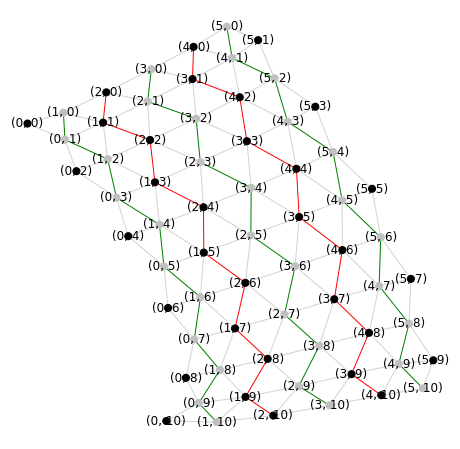

In [125]:
%matplotlib inline

N=10
choice = 2
d_target = 15


G0 = create_data(N,choice)
#print("created",i,len(G0.edges()))
edge = len(G0.copy().edges())
H = G0.copy()

Plot2D(H,8)

print("L =",edge,"d = ",calculate_delta(H),"f = ",frustration_count(H))

50
finished annealing L = 165 d =  50 f =  86
18 68
[75.87252402305603]


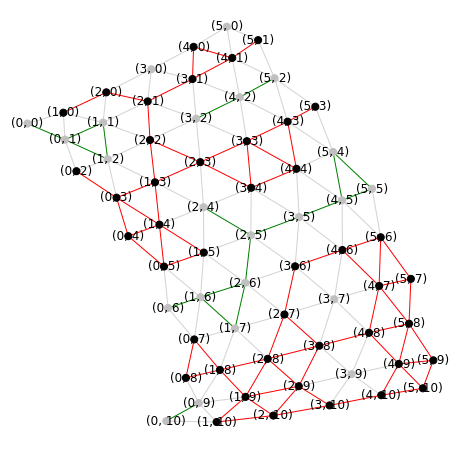

In [148]:
d_target = 50

H = G0.copy()
solveTime = []
while (calculate_delta(H) != d_target):
    start_time = time.time()
    H = simulated_annealing2(G0.copy(),target=d_target)
    solveTime.append(time.time() - start_time) 

Plot2D(H,8)

print("finished annealing","L =",edge,"d = ",calculate_delta(H),"f = ",frustration_count(H))
p,n = color_of_frustration(H)
print(p,n)
print(solveTime)

In [147]:
Properties(H)

N:  66
L:  165
f:  78
L-f:  87
f+:  64
f-:  14
Delta:  50
Abs(Delta):  50
k:  4.571428571428571
0.4727272727272727


In [144]:
def Properties(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count(G))
    print("L-f: ",len(G.edges())-frustration_count(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))
        
    print("k: ",positive/negative)

    print(frustration_count(G)/len(G.edges()))

<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Nešto drugo ću probati

In [187]:
import random

def Creation(n,choice):
    
    #G,points = Create_Triangular_Graph(n)
    #G = Add_Weights(G,1.0)
    
    k = 0.5
    
    if choice==1:
        G = nx.grid_2d_graph(n,n)
    if choice==2:
        G = nx.triangular_lattice_graph(n,n)
    if choice==3:
        G= nx.path_graph(n)

    N = len(G.nodes())
    
    #print("nodes",N)
    #m=int(round(k*N))
    #n=int(round((1-k)*N))
    
    
    m = random.randrange(0,N)
    n = N-m
    
    #print(m,n,m+n)

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    #Properties(G)
    """
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Create_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    """
    
    return G

In [188]:
G = Creation(10,1)

In [192]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [219]:
from collections import Counter

def Create_Initial_Graphs2(repeat_num,choice,N,delta = 0):

    Gs = []
    d_target = delta
    
    for i in tqdm(range(repeat_num)):
        
        starting_Gs = []
        for i in range(5):
            starting_Gs.append(Creation(N,choice))
           
        sdelta = []
        for index,gs in enumerate(starting_Gs):
            sdelta.append(calculate_delta(gs))
        
        idx = np.abs(np.array(sdelta)-d_target).argmin()

        G0 = starting_Gs[idx]
            
        #print("created",i,len(G0.edges()))
        edge = len(G0.copy().edges())
        H = G0.copy() 

        while (calculate_delta(H) != d_target):

            H = simulated_annealing(G0.copy(),target=d_target)

        Gs.append(H.copy())
        #print("finished annealing","d =",calculate_delta(H),"f =",frustration_count(H))
        
    avg_f = []
    for gs in Gs:
        avg_f.append(frustration_count(gs))

    avg_F = Counter(avg_f)
    
    most_common = max(avg_F, key=avg_F.get)
    
    GS = []
    for gs in Gs:
        if frustration_count(gs) == most_common:
            GS.append(gs)
        if len(GS) == 100:
            break
    
        
    return GS
    

In [220]:
repeat_num = 500
N = 10
delta = 50

Gs = Create_Initial_Graphs2(repeat_num,2,N,delta)

Edge = len(Gs[0].copy().edges())

  1%|          | 3/500 [01:06<3:02:57, 22.09s/it]


KeyboardInterrupt: 

In [ ]:
d = 7
[0,10,2,5,6]

# Faster Simulated Annealing

In [233]:
from scipy.optimize import dual_annealing

func = lambda x: np.sum(x*x - 10*np.cos(2*np.pi*x)) + 10*np.size(x)

lw = [-5.12] * 10

up = [5.12] * 10

ret = dual_annealing(func, bounds=list(zip(lw, up)))

ret.x

array([-4.92512701e-09, -4.73101558e-09, -4.52120728e-09, -3.57027657e-09,
       -5.29601648e-09, -5.54740221e-09, -4.79008328e-09, -3.03359307e-09,
       -4.53692523e-09, -1.23030941e-09])

In [229]:
ret.fun

2.842170943040401e-14

In [236]:

def func2(x):
    
    return np.sum(x*x - 10*np.cos(2*np.pi*x)) + 10*np.size(x)

lw = [-5.12] * 100

up = [5.12] * 100

print(lw,up)

ret = dual_annealing(func2, bounds=list(zip(lw, up)))

ret.x

[-5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12, -5.12] [5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12, 5.12

array([-3.21219000e-08, -5.36967212e-09, -4.51958914e-09, -8.57228206e-09,
       -6.06895831e-09, -3.17428472e-09, -2.59129218e-08, -6.34530901e-09,
       -3.16565490e-08, -4.98231129e-09, -4.68485896e-09, -4.15757251e-09,
       -4.14717851e-09, -3.37047864e-09, -2.68532552e-08, -5.55159908e-09,
       -2.40571806e-08, -3.26756354e-08, -3.15155096e-08, -8.96205212e-09,
       -4.69540478e-09, -6.12828366e-09, -2.67475880e-08, -2.55270001e-09,
       -5.70104799e-09, -5.62616607e-09, -1.95069457e-08, -8.01454418e-09,
       -3.70918853e-09, -2.73846047e-08, -5.33683343e-09, -4.37327532e-09,
       -2.58536362e-08, -1.66029728e-08, -1.93519143e-08, -7.79232836e-09,
       -1.77522906e-08, -2.70636911e-08, -1.89150036e-08, -3.64807391e-09,
       -3.14322919e-08, -1.54549143e-08, -1.85029391e-08, -2.86203569e-08,
       -7.65863388e-10, -2.71009654e-08, -2.62400267e-08, -2.50597944e-08,
       -5.34874428e-09, -4.55847881e-09, -5.06480744e-09, -4.70167606e-09,
       -2.89251816e-08, -

# Simulated annealing 


https://nathanrooy.github.io/posts/2020-05-14/simulated-annealing-with-python/

In [237]:
#--- IMPORT DEPENDENCIES ------------------------------------------------------+

from random import randint
from random import random
from math import exp
from math import log

#--- MAIN ---------------------------------------------------------------------+

class minimize():
    '''Simple Simulated Annealing
    '''

    def __init__(self, func, x0, opt_mode, cooling_schedule='linear', step_max=1000, t_min=0, t_max=100, bounds=[], alpha=None, damping=1):

        # checks
        assert opt_mode in ['combinatorial','continuous'], 'opt_mode must be either "combinatorial" or "continuous"'
        assert cooling_schedule in ['linear','exponential','logarithmic', 'quadratic'], 'cooling_schedule must be either "linear", "exponential", "logarithmic", or "quadratic"'


        # initialize starting conditions
        self.t = t_max
        self.t_max = t_max
        self.t_min = t_min
        self.step_max = step_max
        self.opt_mode = opt_mode
        self.hist = []
        self.cooling_schedule = cooling_schedule

        self.cost_func = func
        self.x0 = x0
        self.bounds = bounds[:]
        self.damping = damping
        self.current_state = self.x0
        self.current_energy = func(self.x0)
        self.best_state = self.current_state
        self.best_energy = self.current_energy


        # initialize optimization scheme
        if self.opt_mode == 'combinatorial': self.get_neighbor = self.move_combinatorial
        if self.opt_mode == 'continuous': self.get_neighbor = self.move_continuous


        # initialize cooling schedule
        if self.cooling_schedule == 'linear':
            if alpha != None:
                self.update_t = self.cooling_linear_m
                self.cooling_schedule = 'linear multiplicative cooling'
                self.alpha = alpha

            if alpha == None:
                self.update_t = self.cooling_linear_a
                self.cooling_schedule = 'linear additive cooling'

        if self.cooling_schedule == 'quadratic':
            if alpha != None:
                self.update_t = self.cooling_quadratic_m
                self.cooling_schedule = 'quadratic multiplicative cooling'
                self.alpha = alpha

            if alpha == None:
                self.update_t = self.cooling_quadratic_a
                self.cooling_schedule = 'quadratic additive cooling'

        if self.cooling_schedule == 'exponential':
            if alpha == None: self.alpha =  0.8
            else: self.alpha = alpha
            self.update_t = self.cooling_exponential

        if self.cooling_schedule == 'logarithmic':
            if alpha == None: self.alpha =  0.8
            else: self.alpha = alpha
            self.update_t = self.cooling_logarithmic


        # begin optimizing
        self.step, self.accept = 1, 0
        while self.step < self.step_max and self.t >= self.t_min and self.t>0:

            # get neighbor
            proposed_neighbor = self.get_neighbor()

            # check energy level of neighbor
            E_n = self.cost_func(proposed_neighbor)
            dE = E_n - self.current_energy

            # determine if we should accept the current neighbor
            if random() < self.safe_exp(-dE / self.t):
                self.current_energy = E_n
                self.current_state = proposed_neighbor[:]
                self.accept += 1

            # check if the current neighbor is best solution so far
            if E_n < self.best_energy:
                self.best_energy = E_n
                self.best_state = proposed_neighbor[:]

            # persist some info for later
            self.hist.append([
                self.step,
                self.t,
                self.current_energy,
                self.best_energy])

            # update some stuff
            self.t = self.update_t(self.step)
            self.step += 1

        # generate some final stats
        self.acceptance_rate = self.accept / self.step


    def move_continuous(self):
        # preturb current state by a random amount
        neighbor = [item + ((random() - 0.5) * self.damping) for item in self.current_state]

        # clip to upper and lower bounds
        if self.bounds:
            for i in range(len(neighbor)):
                x_min, x_max = self.bounds[i]
                neighbor[i] = min(max(neighbor[i], x_min), x_max)

        return neighbor


    def move_combinatorial(self):
        '''Swaps two random nodes along path
        Not the most efficient, but it does the job...
        '''
        p0 = randint(0, len(self.current_state)-1)
        p1 = randint(0, len(self.current_state)-1)

        neighbor = self.current_state[:]
        neighbor[p0], neighbor[p1] = neighbor[p1], neighbor[p0]

        return neighbor


    def results(self):
        print('+------------------------ RESULTS -------------------------+\n')
        print(f'      opt.mode: {self.opt_mode}')
        print(f'cooling sched.: {self.cooling_schedule}')
        if self.damping != 1: print(f'       damping: {self.damping}\n')
        else: print('\n')

        print(f'  initial temp: {self.t_max}')
        print(f'    final temp: {self.t:0.6f}')
        print(f'     max steps: {self.step_max}')
        print(f'    final step: {self.step}\n')

        print(f'  final energy: {self.best_energy:0.6f}\n')
        print('+-------------------------- END ---------------------------+')

    # linear multiplicative cooling
    def cooling_linear_m(self, step):
        return self.t_max /  (1 + self.alpha * step)

    # linear additive cooling
    def cooling_linear_a(self, step):
        return self.t_min + (self.t_max - self.t_min) * ((self.step_max - step)/self.step_max)

    # quadratic multiplicative cooling
    def cooling_quadratic_m(self, step):
        return self.t_min / (1 + self.alpha * step**2)

    # quadratic additive cooling
    def cooling_quadratic_a(self, step):
        return self.t_min + (self.t_max - self.t_min) * ((self.step_max - step)/self.step_max)**2

    # exponential multiplicative cooling
    def cooling_exponential_m(self, step):
        return self.t_max * self.alpha**step

    # logarithmical multiplicative cooling
    def cooling_logarithmic_m(self, step):
        return self.t_max / (self.alpha * log(step + 1))

